In [1]:
import time
import init
import environment
import agent
from utils import *

init.set_seed(114514)
%config InlineBackend.figure_format='retina'
%matplotlib inline

path_width = environment.PATH_WIDTH
colors = ["red", "orangered", "darkorange", "orange", "gold", "yellow", "greenyellow", "limegreen", "green"]

In [2]:
env = environment.Environment(5000)
car = agent.Agent()
env.reset(car)

In [3]:
q_table = np.load("last7.npy")
assert q_table.shape[0] * q_table.shape[1] == car.num_states * car.num_actions, "???"
# plot_single_heatmap(q_table, square=False)
del q_table
car.load_q_tabel("last7.npy")

True

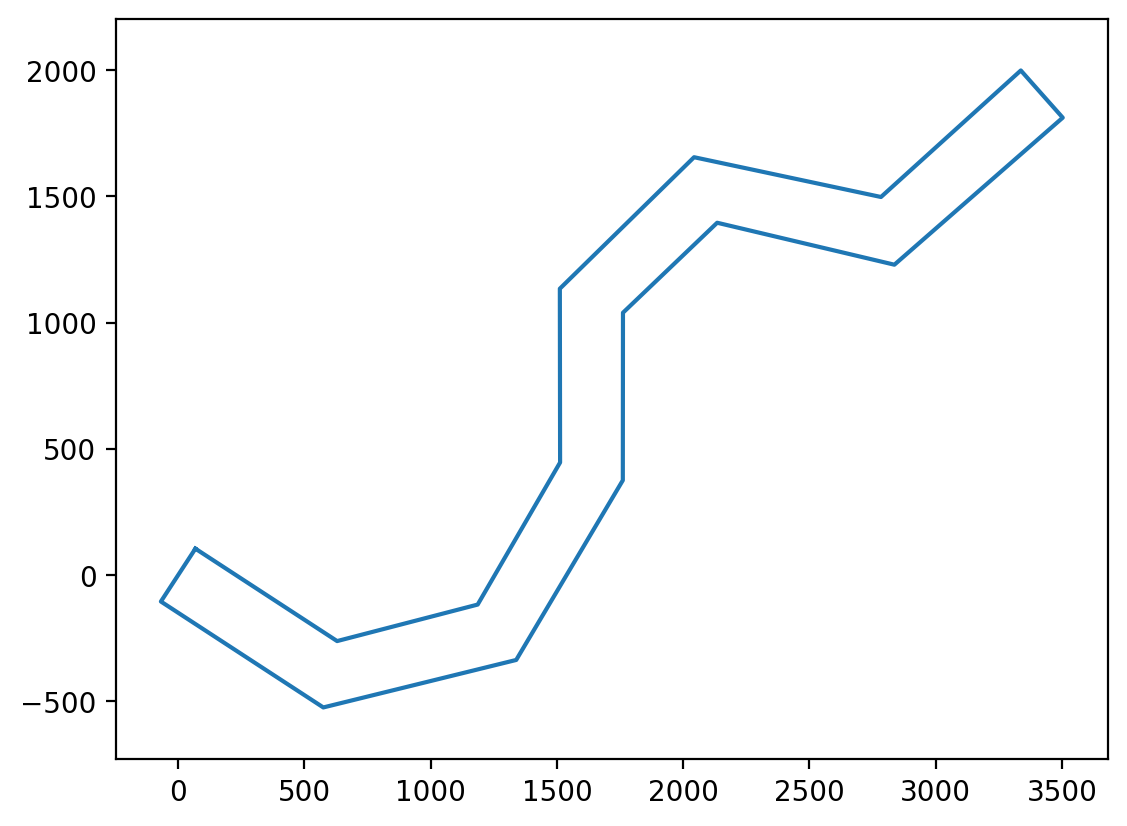

In [4]:
plot(*env.road_polygon.T[::-1], axis="equal")

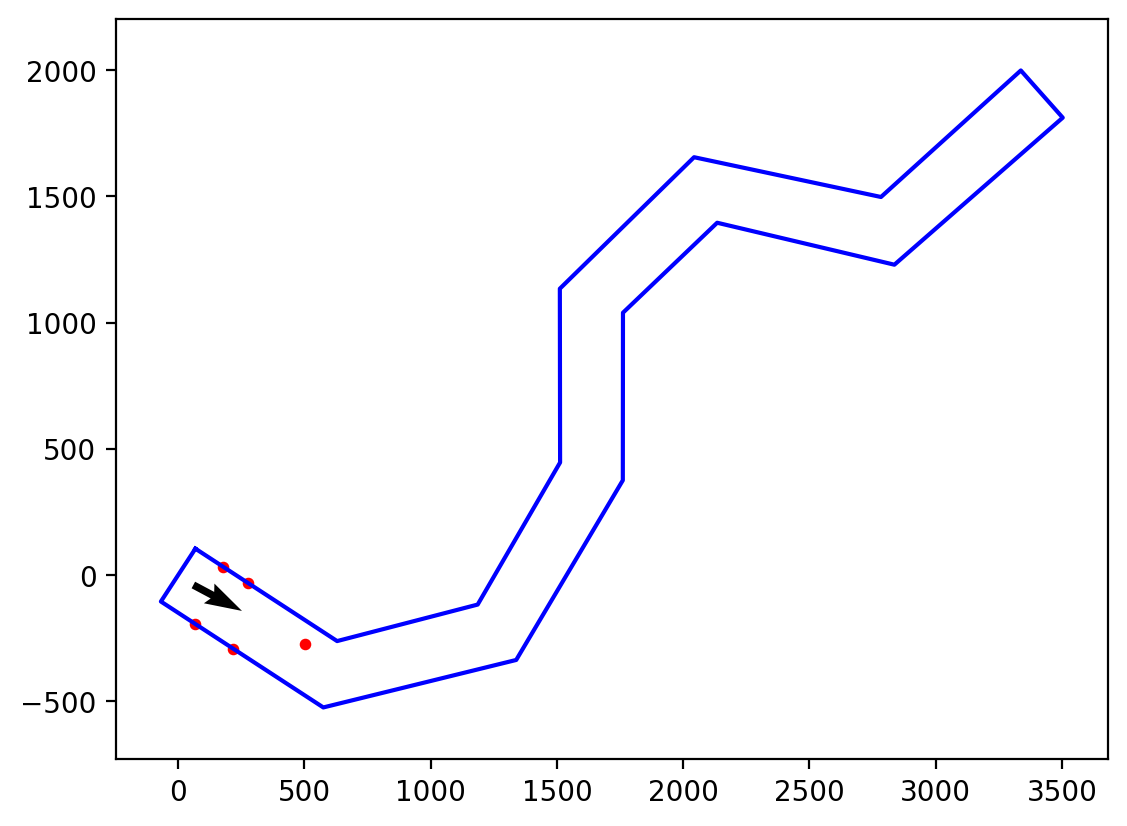

In [5]:
observation = env.observe(car)[1]
plt.axis('equal')
plt.grid(0)
plt.plot(*env.road_polygon.T, c="b")
plt.quiver(*car.position, *car.direction)
plt.scatter(*observation.T[:2], s=10, c="r")
plt.show()

In [6]:
radar_directions = np.array(agent.RADAR_DIRS).reshape(-1,1) + np.pi / 2
radar_directions = theta_e(radar_directions)

In [7]:
def plot_board(envi: environment.Environment, agnt:agent.Agent , obs:np.ndarray, dirs, action):
    fig = plt.figure(figsize=(9, 6), dpi=200)
    spec = fig.add_gridspec(nrows=3,ncols=2,width_ratios=[5, 2],height_ratios=[1,1,1])

    ax0 = fig.add_subplot(spec[:2, :1])
    ax0.axis("equal")
    ax0.axes.xaxis.set_major_locator(plt.NullLocator())
    ax0.axes.yaxis.set_major_locator(plt.NullLocator())
    ax0.grid(0)
    ax0.plot(*envi.road_polygon.T, "b")
    ax0.quiver(*agnt.position, *car.direction)
    ax0.plot(*np.array(agnt.hist_pos).T, "r--")
    ax0.scatter(*obs.T[:2], c="r")

    ax1 = fig.add_subplot(spec[0, 1])
    ax1.axis("equal")
    ax1.axes.xaxis.set_major_locator(plt.NullLocator())
    ax1.axes.yaxis.set_major_locator(plt.NullLocator())
    # ax1.set_xlim(-path_width*2, +path_width*2)
    ax1.set_ylim(-50, +path_width*2)
    ax1.grid(0)
    ax1.scatter(*(dirs*path_width*2).T, c="g", s=8)
    ax1.scatter(0, 0, c="b", s=10)
    color_digitized = np.digitize(obs.T[-1] / path_width, agnt.radar_bins)
    for i, r in enumerate(obs.T[-1]):
        x, y = r * dirs[i]
        ax1.plot([0, x], [0, y], color=colors[color_digitized[i]])


    ax2 = fig.add_subplot(spec[1, 1])
    ax2.axis("equal")
    ax2.grid(0)
    ax2.axes.xaxis.set_major_locator(plt.NullLocator())
    ax2.axes.yaxis.set_major_locator(plt.NullLocator())
    ax2.set_xlim(-1, agnt.num_r_actions)
    ax2.set_ylim(-1, agnt.num_acc_actions)
    acc, r = action % agnt.num_acc_actions, action // agnt.num_acc_actions
    ax2.scatter(r, acc, c="r", s=100)

    ax3 = fig.add_subplot(spec[2, :])
    ax3.grid(0)
    ax3.plot(agnt.hist_v)

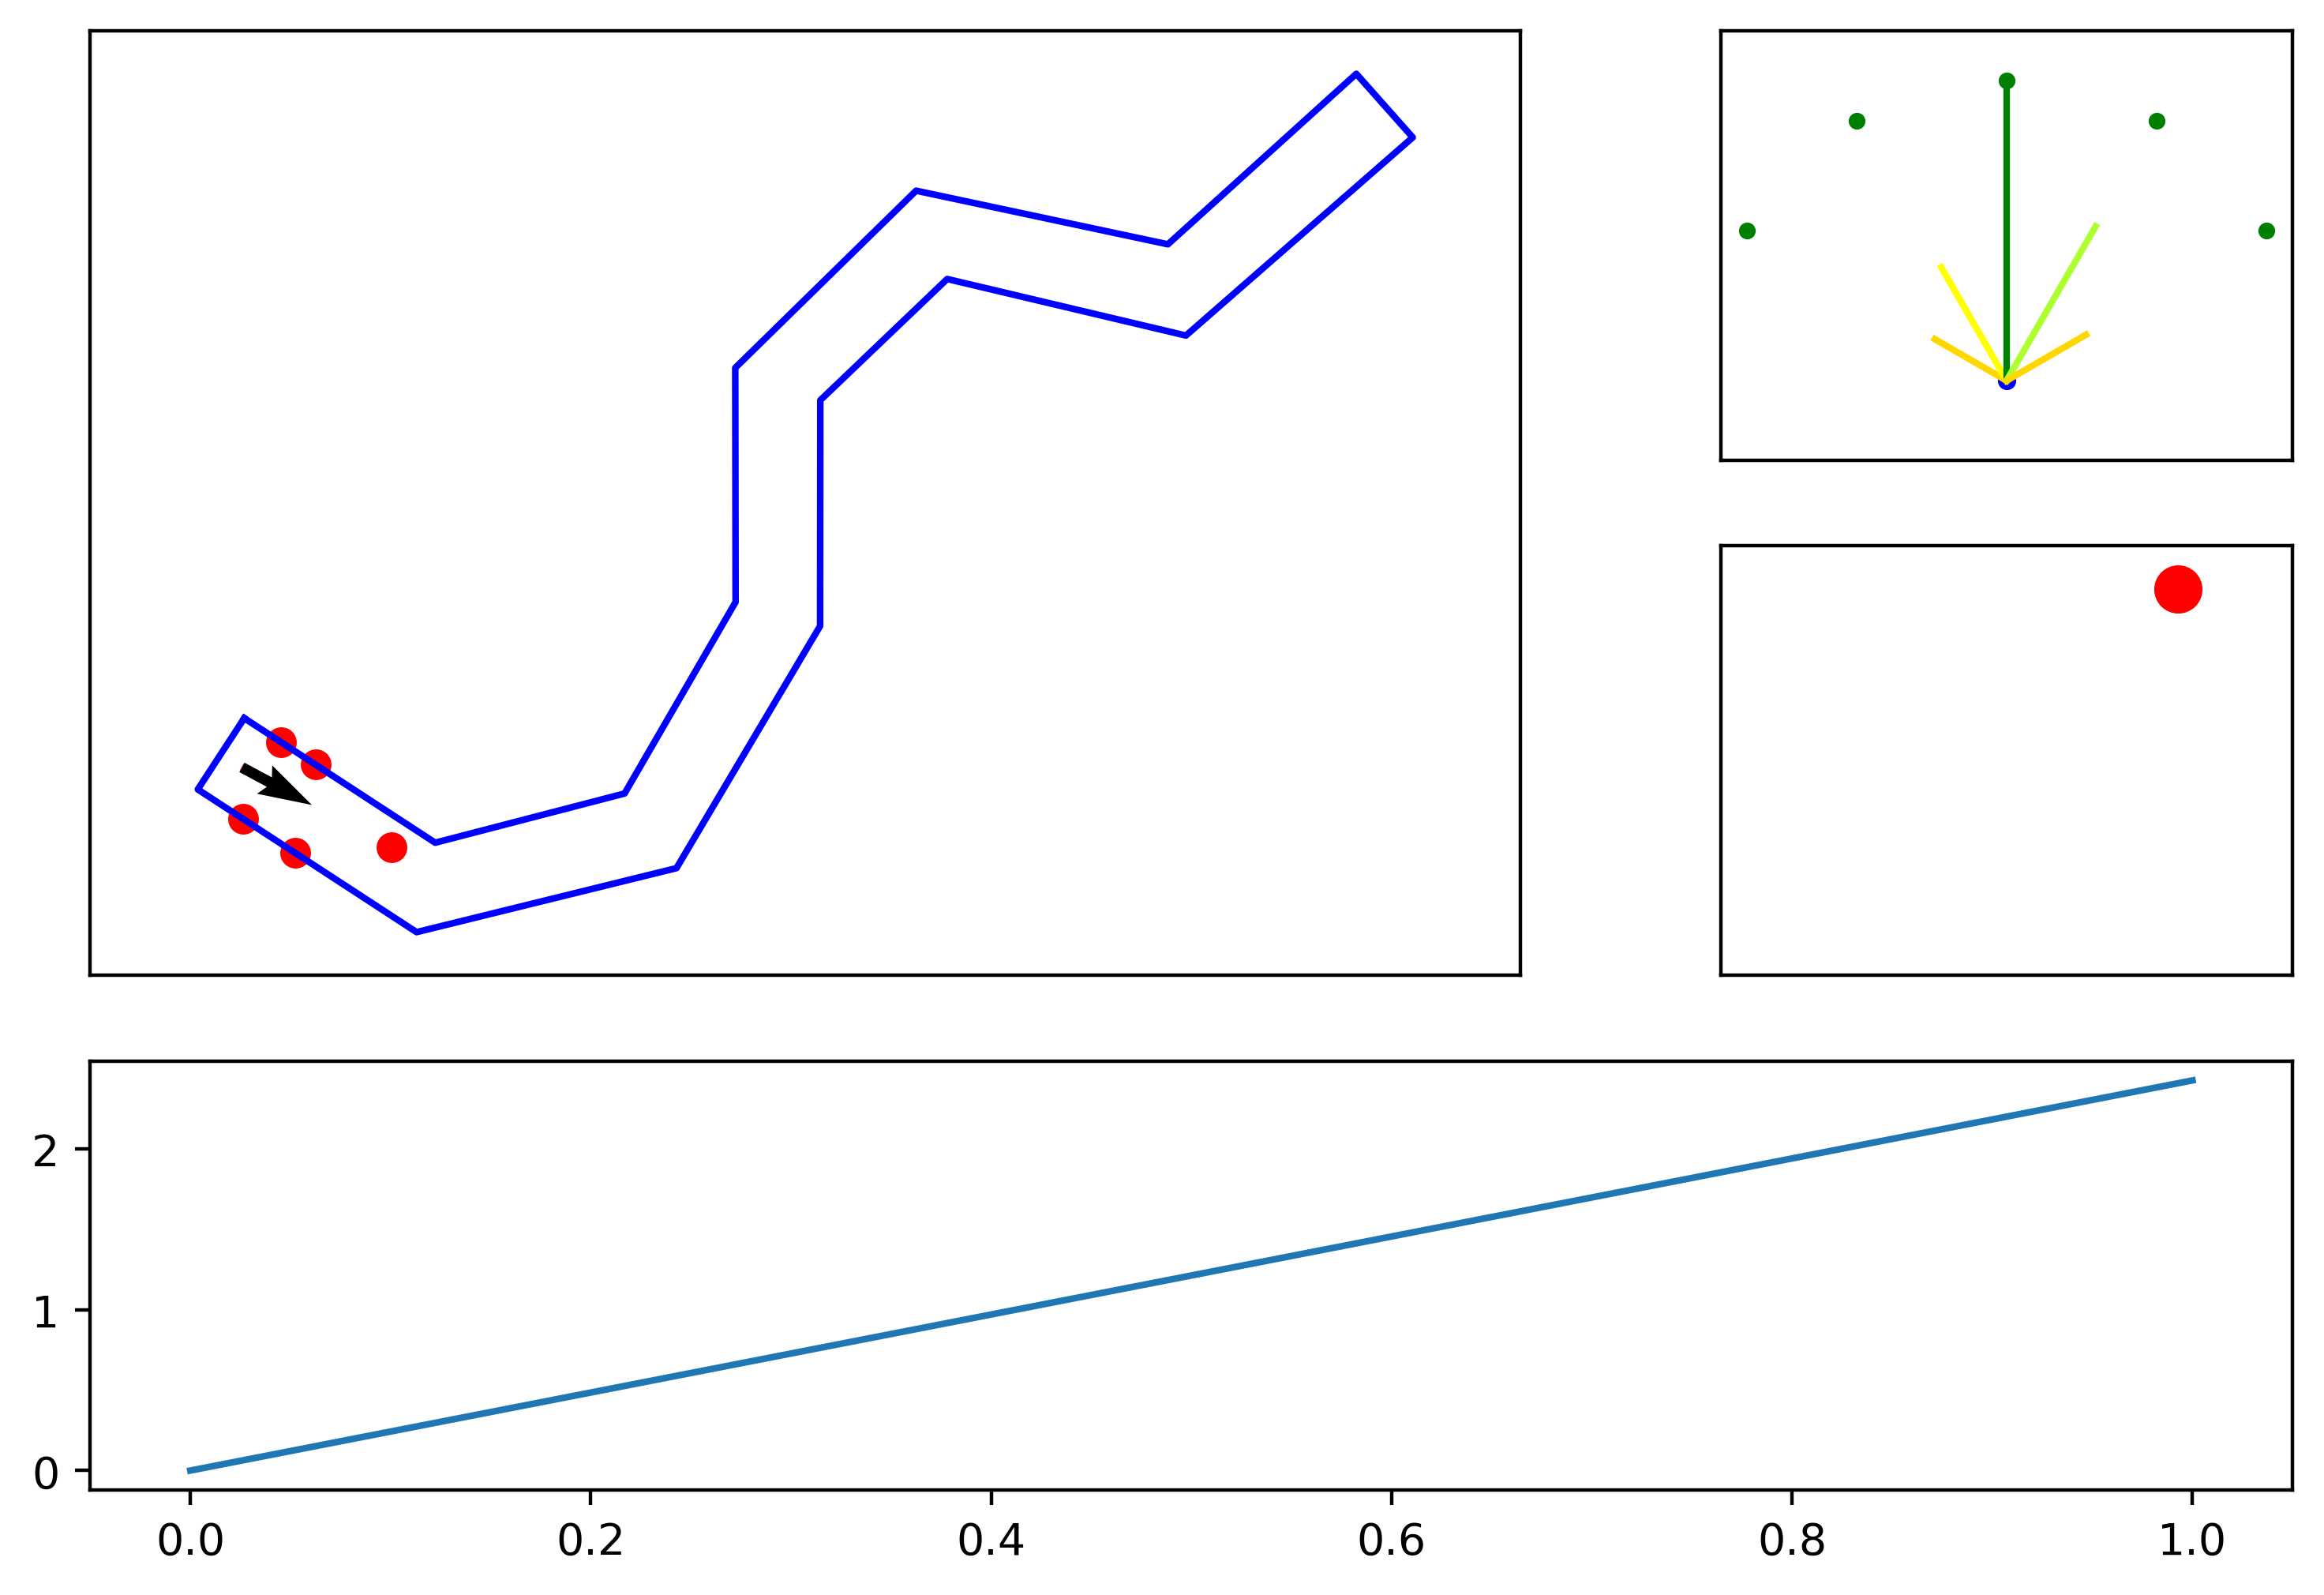

In [8]:
action_made = car.step_next(
    observation=(observation.T[-1], car.velocity),
    training=False
)
plot_board(env, car, observation, radar_directions, action_made)
plt.show()

# 测试完毕！开始dynamic show!!

# 以下使用gif画画已经弃用，原因：太慢！画画大约耗时2-3min。

In [9]:
import gif
t0 = time.time()
@gif.frame
def refresh_gif(envi: environment.Environment, agent_:agent.Agent , obs:np.ndarray, dirs, action):
    plot_board(envi, agent_, obs, dirs, action)

frames = []

env.reset(car)
in_road, observation = env.observe(car)

while in_road != -1:
    radar_observation = observation.T[-1]

    action_made = car.step_next(
        observation=(radar_observation, car.velocity),
        training=False
    )
    frames.append(refresh_gif(env, car, observation, radar_directions, action_made))
    in_road, passed, _ = env.completion(car.position)

    if passed / env.tot_length > 0.95:
        in_road = -1
    observation = env.observe(car)[1]

gif.save(frames, "gif.gif", duration=20)

print(f"Time Cost:{time.time() - t0:0.4f}s")

del observation

Time Cost:176.8410s


![](gif.gif)

Time Cost:0.7472s


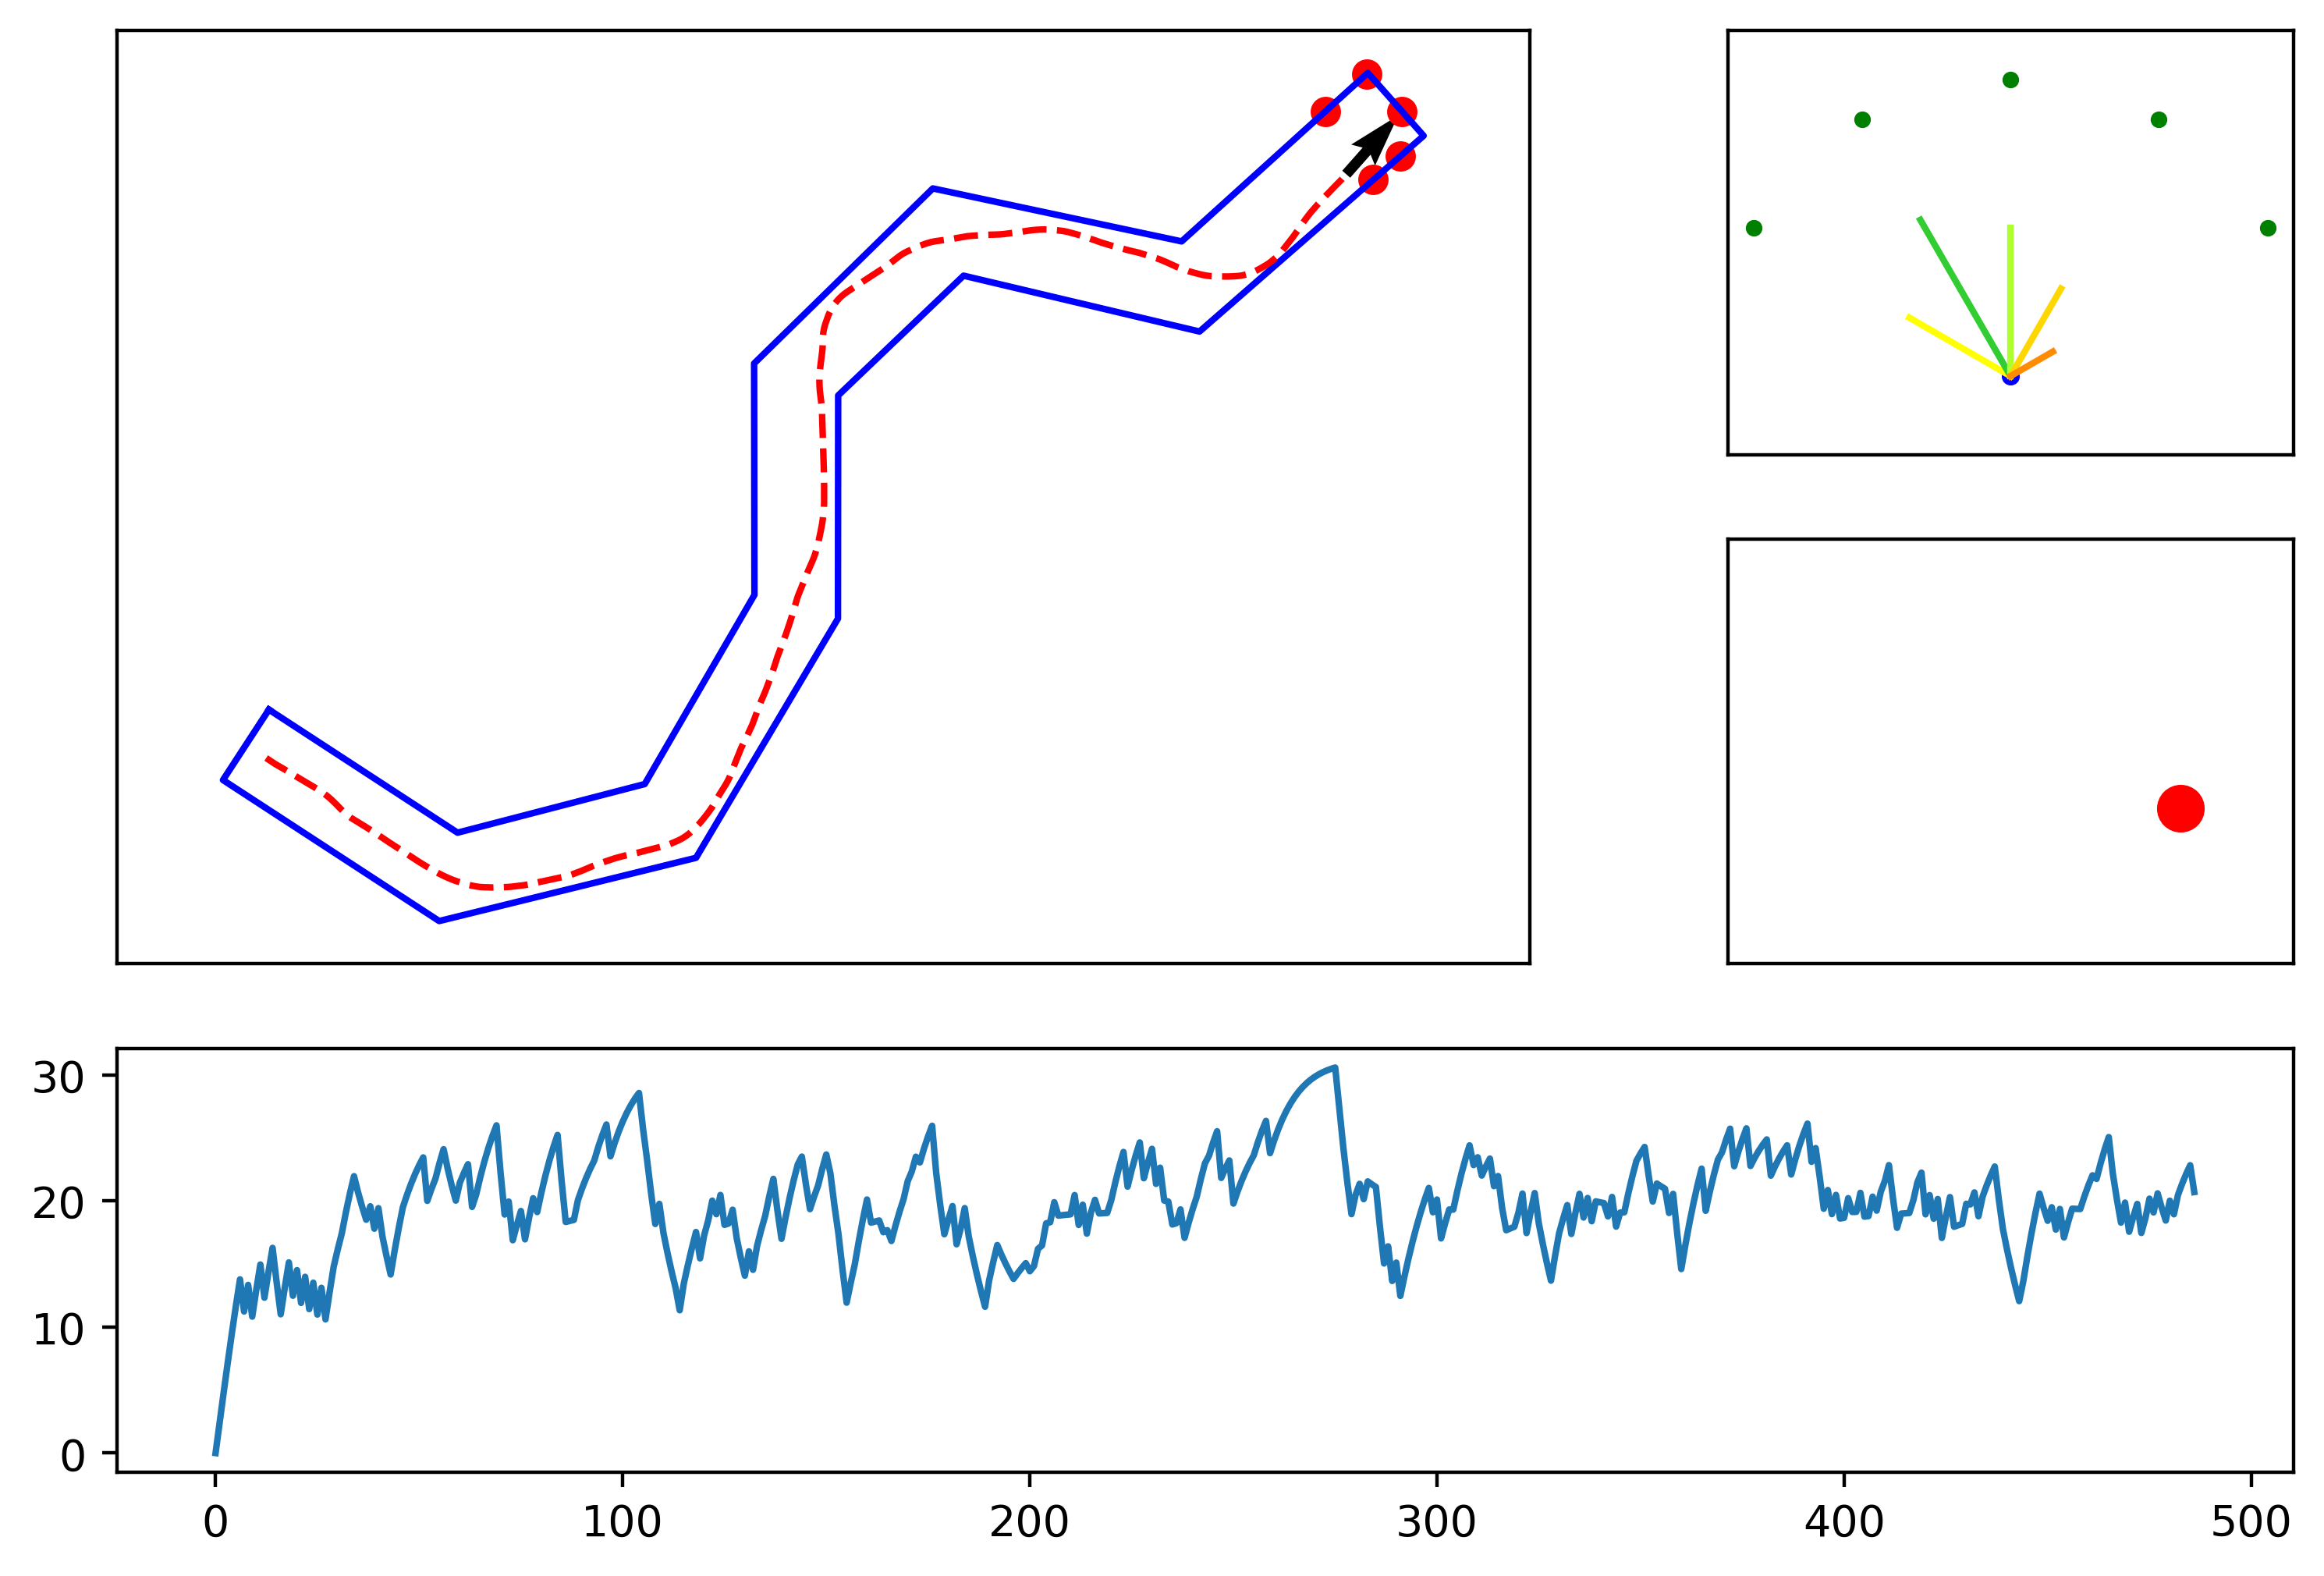

In [10]:
t0 = time.time()

env.reset(car, recreate_road=False)
in_road, observation = env.observe(car)

while in_road != -1:
    radar_observation = observation.T[-1]

    action_made = car.step_next(
        observation=(radar_observation, car.velocity),
        training=False
    )

    in_road, passed, _ = env.completion(car.position)
    if passed / env.tot_length > 0.95:
        in_road = -1
    observation = env.observe(car)[1]

plot_board(env, car, observation, radar_directions, action_made)
print(f"Time Cost:{time.time() - t0:0.4f}s")

# gif库绘制gif实在是太慢太慢了！！！！！！如果不画gif那么1s不用就算完且画好了。

Time Cost:158.4863s


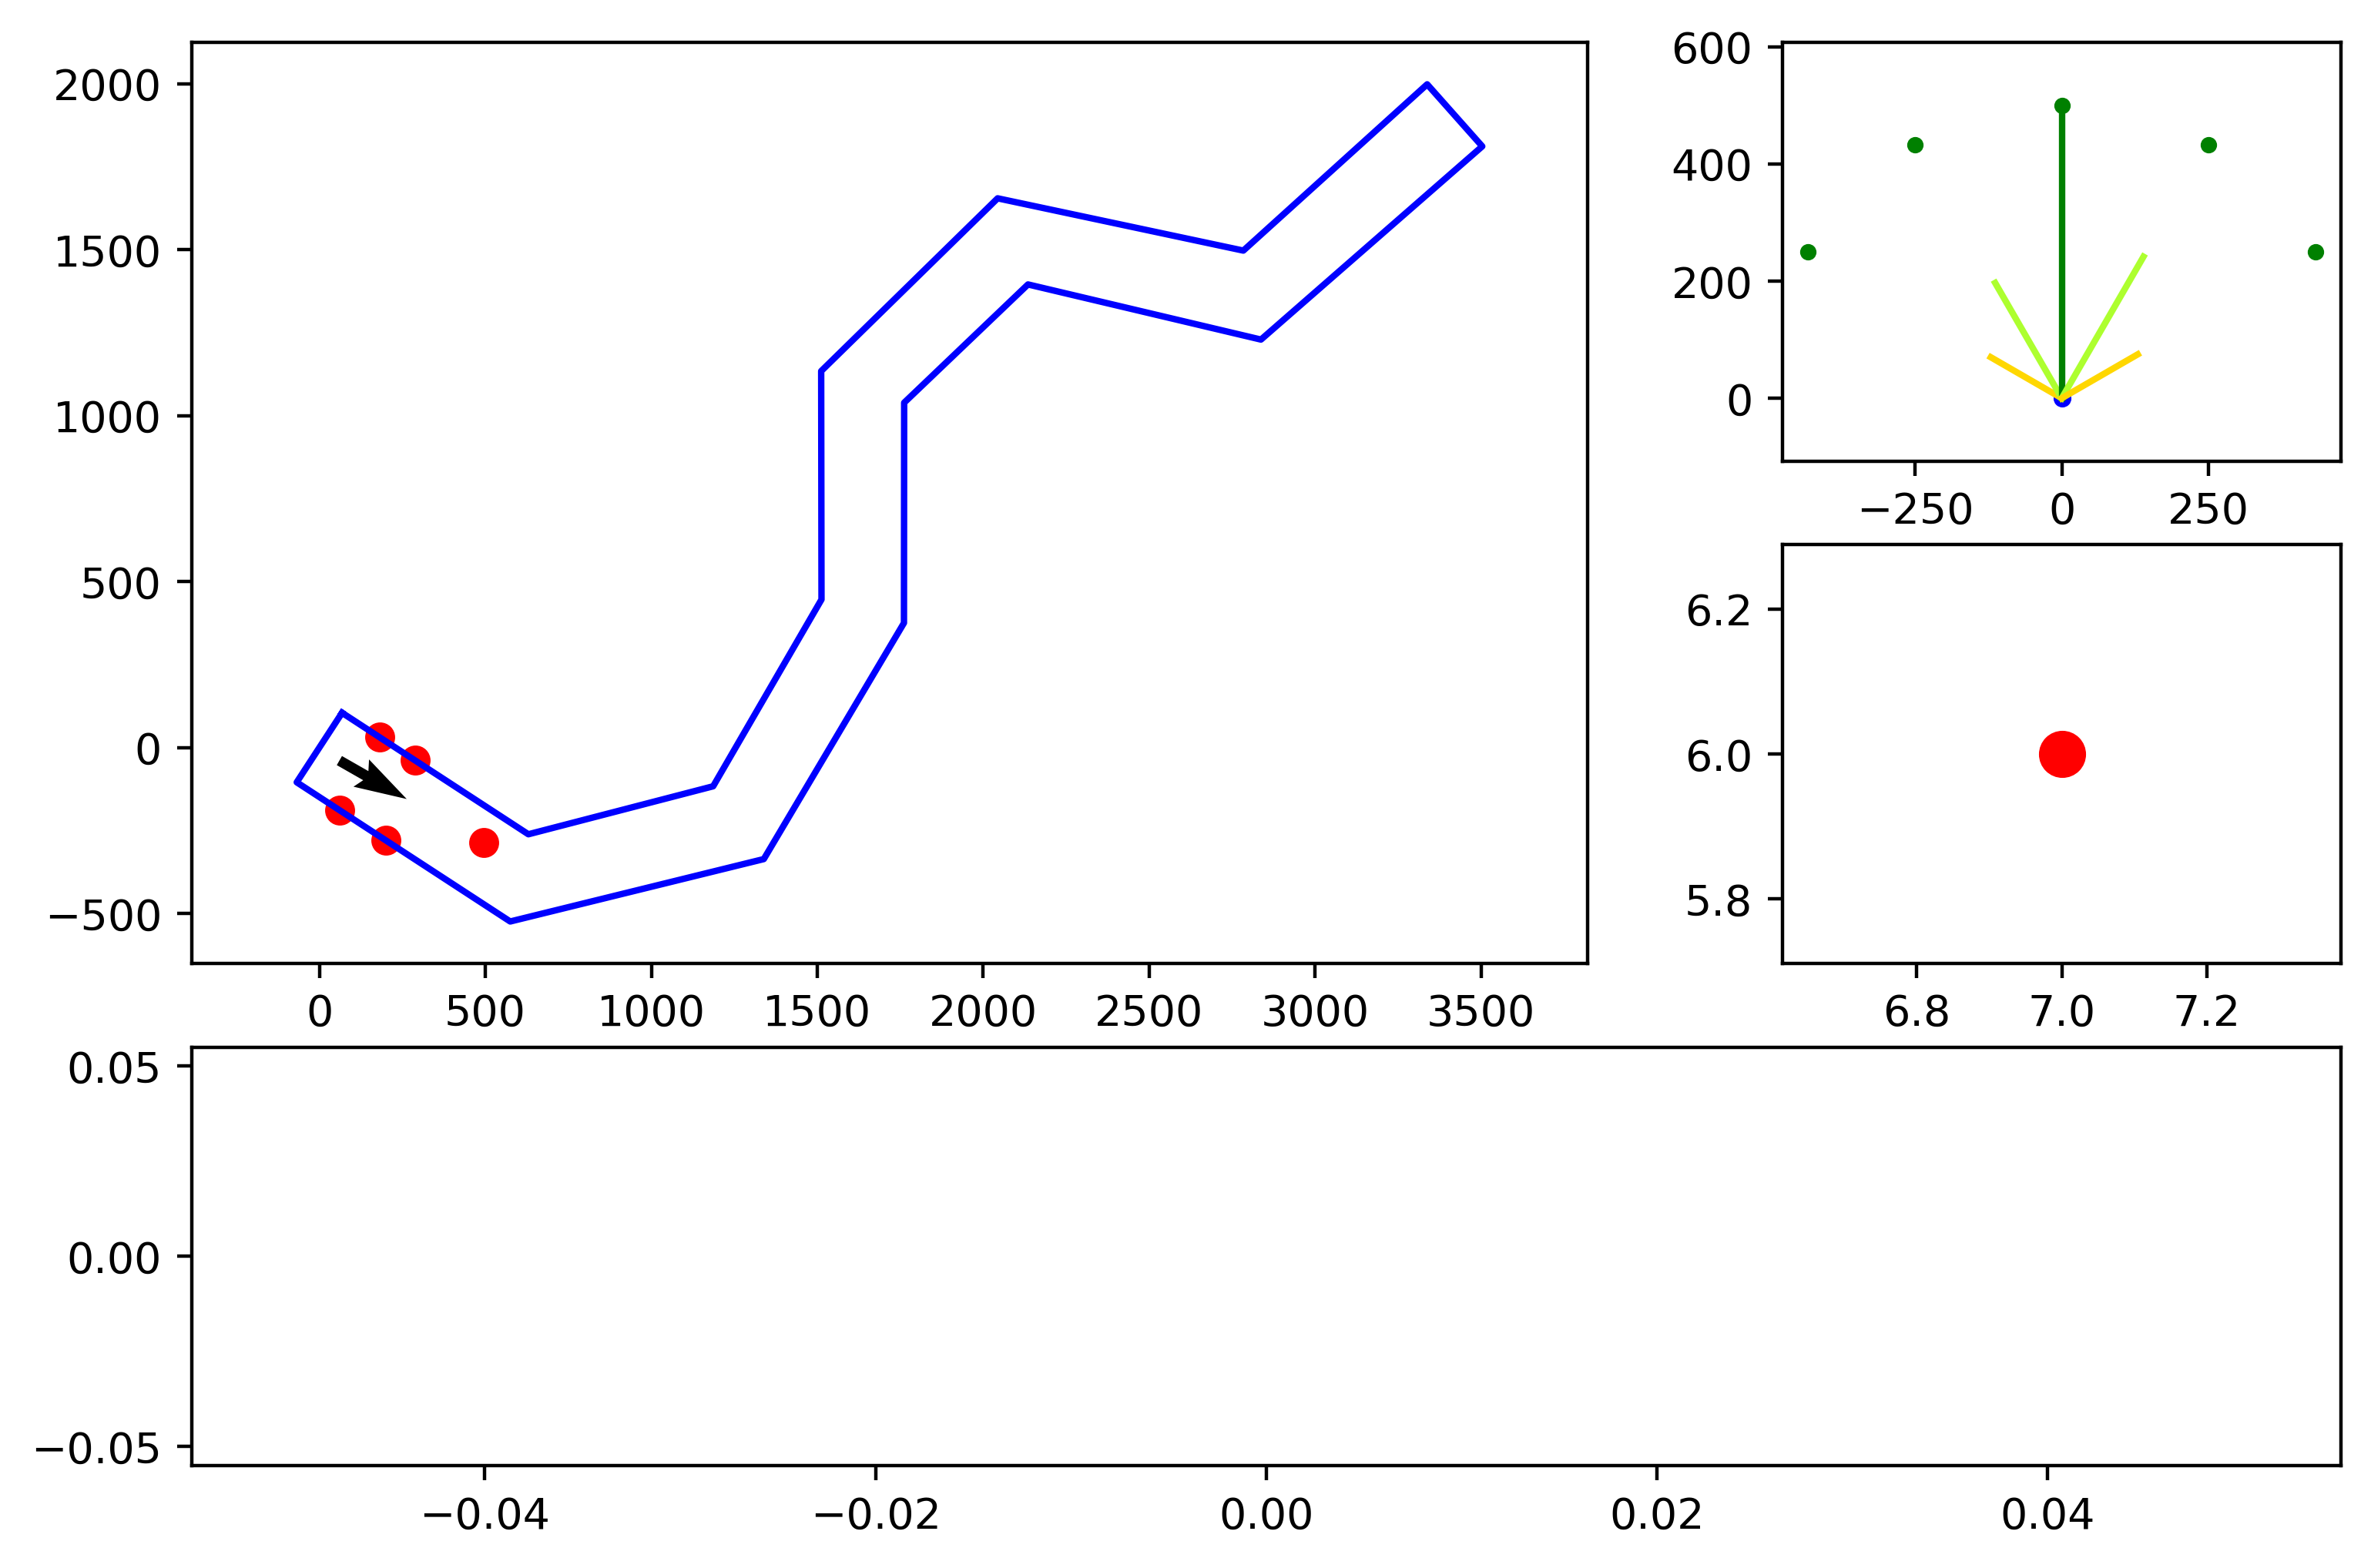

In [11]:
from matplotlib.animation import FuncAnimation
t0 = time.time()

fig = plt.figure(figsize=(9, 6), dpi=200)
spec = fig.add_gridspec(nrows=3,ncols=2,width_ratios=[5, 2],height_ratios=[1,1,1])
ax0 = fig.add_subplot(spec[:2, :1])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])
ax3 = fig.add_subplot(spec[2, :])
ax0.axis("equal")
ax0.axes.xaxis.set_major_locator(plt.NullLocator())
ax0.axes.yaxis.set_major_locator(plt.NullLocator())
ax0.grid(0)
ax1.axis("equal")
ax1.axes.xaxis.set_major_locator(plt.NullLocator())
ax1.axes.yaxis.set_major_locator(plt.NullLocator())
ax1.set_ylim(-50, +path_width*2)
ax1.grid(0)
ax2.axis("equal")
ax2.axes.xaxis.set_major_locator(plt.NullLocator())
ax2.axes.yaxis.set_major_locator(plt.NullLocator())
ax2.set_xlim(-1, car.num_r_actions)
ax2.set_ylim(-1, car.num_acc_actions)
ax2.grid(0)
ax3.grid(0)

def refresh_board(envi: environment.Environment, agent_:agent.Agent, obs, dirs, action_hist, i):
    history = agent_.get_hist()[:i + 1]
    ax0.cla()
    ax0.plot(*envi.road_polygon.T, "b")
    ax0.quiver(*history[-1][:4])
    ax0.plot(*history.T[:2], "r--")
    ax0.scatter(*obs[i].T[:2], c="r")

    ax1.cla()
    ax1.scatter(*(dirs*path_width*2).T, c="g", s=8)
    ax1.scatter(0, 0, c="b", s=10)
    color_digitized = np.digitize(obs[i].T[-1] / path_width, agent_.radar_bins)
    for j, r in enumerate(obs[i].T[-1]):
        x, y = r * dirs[j]
        ax1.plot([0, x], [0, y], color=colors[color_digitized[j]])

    ax2.cla()
    acc, r = action_hist[i] % agent_.num_acc_actions, action_hist[i] // agent_.num_acc_actions
    ax2.scatter(r, acc, c="r", s=100)

    ax3.cla()
    ax3.plot(agent_.hist_v[:i + 1])

def update(i):
    refresh_board(env, car, observations, radar_directions, actions, i)

env.reset(car, recreate_road=False)
in_road, observation = env.observe(car)
observations = [observation]
actions = []

while in_road != -1:
    radar_observation = observation.T[-1]

    action_made = car.step_next(
        observation=(radar_observation, car.velocity),
        training=False
    )

    in_road, passed, _ = env.completion(car.position)
    if passed / env.tot_length > 0.95:
        in_road = -1
    observation = env.observe(car)[1]

    observations.append(observation)
    actions.append(action_made)

ani = FuncAnimation(fig, update, frames=len(actions), interval=33)
ani.save("ani.gif")

print(f"Time Cost:{time.time() - t0:0.4f}s")

# RNM!

# 好吧大家半斤八两！